In [3800]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
from model import DeeplabV3Plus
from superresolution_scripts.superresolution import Superresolution
from superresolution_scripts.optimizer import Optimizer
from utils import *
from superresolution_scripts.superres_utils import list_precomputed_data_paths, load_SR_data, normalize_coefficients, threshold_image, get_img_paths, filter_images_by_class
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3801]:
IMG_SIZE = (512, 512)
FEATURE_SIZE = (128, 128)
NUM_AUG = 100
CLASS_ID = 8
NUM_SAMPLES = 5

MODE = "argmax"
MODEL_BACKBONE = "xception"
USE_VALIDATION = False
SAVE_SLICE_OUTPUT = False

DATA_DIR = os.path.join(os.getcwd(), "data")
PASCAL_ROOT = os.path.join(DATA_DIR, "dataset_root", "VOCdevkit", "VOC2012")
IMGS_PATH = os.path.join(PASCAL_ROOT, "JPEGImages")

SUPERRES_ROOT = os.path.join(DATA_DIR, "superres_root")
AUGMENTED_COPIES_ROOT = os.path.join(SUPERRES_ROOT, "augmented_copies")
PRECOMPUTED_OUTPUT_DIR = os.path.join(
    AUGMENTED_COPIES_ROOT, f"{MODEL_BACKBONE}_{MODE}_{NUM_AUG}{'_validation' if USE_VALIDATION else ''}")
STANDARD_OUTPUT_ROOT = os.path.join(SUPERRES_ROOT, "standard_output")
STANDARD_OUTPUT_DIR = os.path.join(
    STANDARD_OUTPUT_ROOT, f"{MODEL_BACKBONE}{'_validation' if USE_VALIDATION else ''}")
SUPERRES_OUTPUT_DIR = os.path.join(
    SUPERRES_ROOT, f"superres_output{'_validation' if USE_VALIDATION else ''}")

In [3802]:
test_image_path = os.path.join(IMGS_PATH, "2007_003778.jpg")
# test_image_path = os.path.join(IMGS_PATH, "2010_004327.jpg")


# image_list_path = os.path.join(DATA_DIR, "augmented_file_lists",
#                                 f"{'valaug' if USE_VALIDATION else 'trainaug'}.txt")
# image_paths = get_img_paths(
#     image_list_path, IMGS_PATH, is_png=False, sort=True)
# test_image_path = random.choice(image_paths)
# print(test_image_path)
image = load_image(test_image_path, image_size=IMG_SIZE, normalize=True)

In [3803]:
angle_max = 0.4
shift_max = 50
num_aug = 4

In [3804]:
batched_images = tf.tile(tf.expand_dims(image, axis=0), [num_aug, 1, 1, 1])
# angles = np.random.uniform(-angle_max, angle_max, num_aug)

angles = np.random.uniform(-angle_max, angle_max, num_aug)
shifts = np.random.uniform(-shift_max, shift_max, (num_aug, 2))
# First sample is not augmented
angles[0] = 0
shifts[0] = np.array([0, 0])
angles = angles.astype("float32")
shifts = shifts.astype("float32")

rotated_images = tfa.image.rotate(batched_images, angles, interpolation="bilinear", fill_mode="nearest")
augmented_images = tfa.image.translate(rotated_images, shifts, interpolation="bilinear", fill_mode="nearest")

In [3805]:
model = DeeplabV3Plus(
        input_shape=(512, 512, 3),
        classes=21,
        OS=16,
        last_activation=None,
        load_weights=True,
        backbone=MODEL_BACKBONE,
        alpha=1.).build_model(final_upsample=True)

predictions = model.predict(augmented_images)

In [3806]:
segmentation_masks = np.array([create_mask(mask).numpy() for mask in predictions])
augmented_images = np.array([image.numpy() for image in augmented_images])

In [3807]:
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.colorbar import ColorbarBase

cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (0, 0, 0, 1.0)
# create the new map
cmap = LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(0, 20, 21)
norm = BoundaryNorm(bounds, cmap.N)

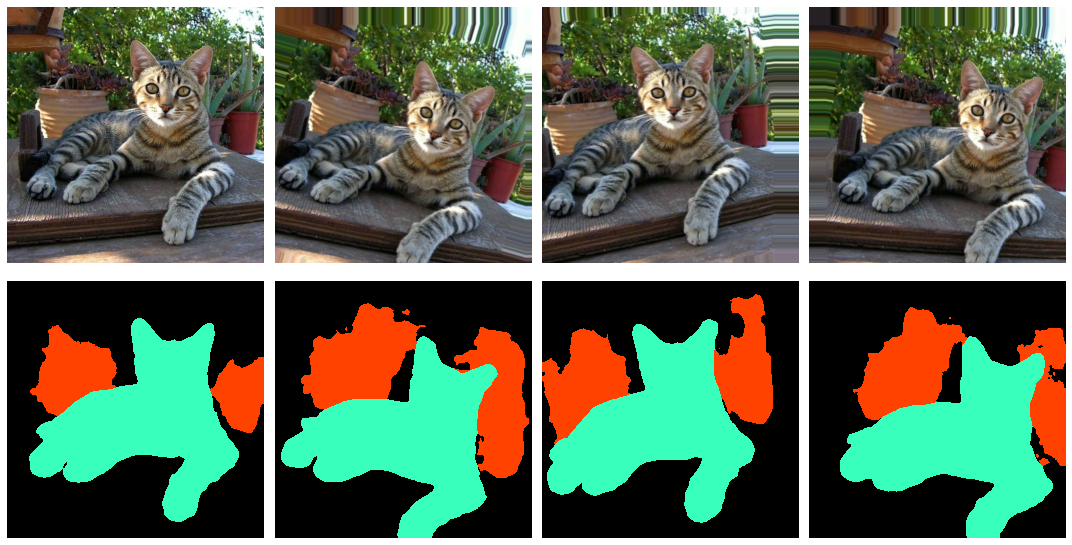

In [3808]:
fig = plt.figure(figsize=(15,8))
# fig = plt.figure()

for i in range(len(augmented_images)):
        plt.subplot(2, 4, i + 1)
        plt.imshow(augmented_images[i])
        plt.axis('off')

for k in range(len(segmentation_masks)):
        plt.subplot(2, 4, 5 + k)
        plt.imshow(augmented_images[k])
        plt.imshow(segmentation_masks[k], cmap=cmap, norm=norm, alpha=1, interpolation="nearest")
        plt.axis("off")

# ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
# cb = ColorbarBase(ax2, cmap=cmap, norm=norm,
#     spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

plt.tight_layout()
plt.show()